## **Import Libraries**

In [45]:
import sys
import heapq
import time
import math
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

## **Read in files**

In [46]:
# Read Final_flights_data.csv file
flights_data = pd.read_csv('./data/final_flights_20_cities.csv')
flights_data.head()

,origin,destination,departure_time,arrival_time,duration,fare,nonstop,layovers
0,EWR,BOS,2024-12-01T21:20:00,2024-12-01T22:39:00,PT1H19M,108.97,True,None
1,EWR,BOS,2024-12-01T13:04:00,2024-12-01T14:25:00,PT1H21M,108.97,True,None
2,LGA,BOS,2024-12-01T06:30:00,2024-12-01T07:40:00,PT1H10M,250.87,True,None
3,LGA,BOS,2024-12-01T08:09:00,2024-12-01T09:20:00,PT1H11M,250.87,True,None
4,JFK,BOS,2024-12-01T23:30:00,2024-12-02T00:41:00,PT1H11M,250.87,True,None


## **Data Cleaning and Preparation**

### 1. Filter layover flights

In [47]:
city_mapping = {
    'NYC': 'New York',
    'JFK': 'New York',
    'LGA': 'New York',
    'EWR': 'New York',
    'BOS': 'Boston',
    'DCA': 'Washington, D.C.',
    'PHL': 'Philadelphia',
    'MIA': 'Miami',
    'OPF': 'Miami',
    'CHS': 'Charleston',
    'ATL': 'Atlanta',
    'LAX': 'Los Angeles',
    'ONT': 'Los Angeles',
    'LAS': 'Las Vegas',
    'SEA': 'Seattle',
    'SAN': 'San Diego',
    'DEN': 'Denver',
    'BJC': 'Denver',
    'PDX': 'Portland',
    'ORD': 'Chicago',
    'DAL': 'Dallas',
    'DFW': 'Dallas',
    'IAH': 'Houston',
    'HOU': 'Houston',
    'STL': 'St. Louis',
    'MCI': 'Kansas City',
    'OKC': 'Oklahoma City',
    'MSP': 'Minneapolis'
}

In [48]:
# Check if layovers are in valid cities
def is_valid_layover(layovers, valid_cities):
    if pd.notnull(layovers):  # If layovers are not null
        layover_list = layovers.split(',') if isinstance(layovers, str) else layovers
        return all(city in valid_cities for city in layover_list)
    return True  # No layovers, or null, consider it valid
valid_cities = set(city_mapping.keys())


In [49]:
flights_data_filtered = flights_data[
    flights_data['origin'].isin(valid_cities) & 
    flights_data['destination'].isin(valid_cities) & 
    ((flights_data['nonstop'] == True) | flights_data['layovers'].apply(lambda x: is_valid_layover(x, valid_cities))) # remove those invalid cities
]
flights_data_filtered.head()

,origin,destination,departure_time,arrival_time,duration,fare,nonstop,layovers
0,EWR,BOS,2024-12-01T21:20:00,2024-12-01T22:39:00,PT1H19M,108.97,True,None
1,EWR,BOS,2024-12-01T13:04:00,2024-12-01T14:25:00,PT1H21M,108.97,True,None
2,LGA,BOS,2024-12-01T06:30:00,2024-12-01T07:40:00,PT1H10M,250.87,True,None
3,LGA,BOS,2024-12-01T08:09:00,2024-12-01T09:20:00,PT1H11M,250.87,True,None
4,JFK,BOS,2024-12-01T23:30:00,2024-12-02T00:41:00,PT1H11M,250.87,True,None


### 2. Map airports to cities

In [50]:
cities_east = ['New York', 'Boston', 'Washington, D.C.', 'Philadelphia', 'Miami', 'Charleston', 'Atlanta']
cities_west = ['Los Angeles', 'Las Vegas', 'Seattle', 'San Diego', 'Denver', 'Portland']
cities_mid = ['Chicago', 'Dallas', 'Houston', 'St. Louis', 'Kansas City', 'Oklahoma City', 'Minneapolis']

In [51]:
# Add city full name
flights_data_filtered['origin_city'] = flights_data_filtered['origin'].map(city_mapping)
flights_data_filtered['destination_city'] = flights_data_filtered['destination'].map(city_mapping)
flights_data_filtered['layovers_city'] = flights_data_filtered['layovers'].map(city_mapping)

/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/2399958271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered['origin_city'] = flights_data_filtered['origin'].map(city_mapping)
/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/2399958271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered['destination_city'] = flights_data_filtered['destination'].map(city_mapping)
/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/239

### 3. Calculate and format departure and arrival time to minutes

In [52]:
flights_data_filtered['departure_time'] = pd.to_datetime(flights_data_filtered['departure_time'])
flights_data_filtered['arrival_time'] = pd.to_datetime(flights_data_filtered['arrival_time'])
# Remove the "PT" prefix and correctly extract hours and minutes
flights_data_filtered['duration'] = flights_data_filtered['duration'].str[2:]
# Extract hours and minutes
flights_data_filtered['HOUR'] = flights_data_filtered['duration'].apply(lambda x: int(x.split('H')[0]) if 'H' in x else 0)
flights_data_filtered['MIN'] = flights_data_filtered['duration'].apply(lambda x: int(x.split('M')[0].split('H')[-1]) if 'M' in x else 0)
# Calculate total minutes from hours and minutes
flights_data_filtered['duration_minutes'] = flights_data_filtered['HOUR'] * 60 + flights_data_filtered['MIN']

/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/3531126273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered['departure_time'] = pd.to_datetime(flights_data_filtered['departure_time'])
/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/3531126273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered['arrival_time'] = pd.to_datetime(flights_data_filtered['arrival_time'])
/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717

### 4. Count number of layovers

In [53]:
flights_data_filtered['layover_count'] = flights_data_filtered['layovers'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/1684713259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered['layover_count'] = flights_data_filtered['layovers'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)


### 5. Order columns names

In [54]:
# Reorder columns to match the required format
flight_df = flights_data_filtered[['origin', 'origin_city', 'destination', 'destination_city','layovers','layovers_city', 'departure_time', 
'arrival_time','duration', 'duration_minutes', 'fare','layover_count']]

### 6. Remove direct flights from east to west

In [55]:
# Remove east to west direct flight
cities_east = ['New York', 'Boston', 'Washington, D.C.', 'Philadelphia', 'Miami', 'Charleston', 'Atlanta']
cities_west = ['Los Angeles', 'Las Vegas', 'Seattle', 'San Diego', 'Denver', 'Portland']
flight_df = flight_df[~(flight_df['origin_city'].isin(cities_east) & flight_df['destination_city'].isin(cities_west))]
flight_df = flight_df[~(flight_df['origin_city'].isin(cities_west) & flight_df['destination_city'].isin(cities_east))]

## **Popualate Filtered Flight Data to Dictionary**

### 1. flight duration data

In [56]:
# The following code constructs the flight_duration_data dictionary
flight_duration_data = {}

# Iterate through each row of the flight data
for index, row in flight_df.iterrows():
    origin = row['origin_city']
    destination = row['destination_city']
    duration_minutes = row['duration_minutes']
    layovers_city = row['layovers_city']
    
    # Initialize the origin city dictionary if not already present
    if origin not in flight_duration_data:
        flight_duration_data[origin] = {}
    
    # If there are no layovers, i.e., direct flight
    if pd.isna(row['layovers_city']):
        if destination not in flight_duration_data[origin]:
            flight_duration_data[origin][destination] = {'direct': duration_minutes}
        else:
            # Update with the shortest direct flight duration if one exists
            flight_duration_data[origin][destination]['direct'] = min(duration_minutes, flight_duration_data[origin][destination].get('direct', duration_minutes))

    # If there is one layover, i.e., 1 stop
    elif row['layover_count'] == 1:
        if destination not in flight_duration_data[origin]:
            flight_duration_data[origin][destination] = {'1 stop': {'duration': duration_minutes, 'layovers': layovers_city}}
            #flight_duration_data[origin][destination] = {'1 stop': duration_minutes}
        
        existing_duration = flight_duration_data[origin][destination].get('1 stop', {}).get('duration', float('inf'))
        
        # Update with the shortest duration and the corresponding layover path
        if duration_minutes < existing_duration:
            flight_duration_data[origin][destination]['1 stop'] = {'duration': duration_minutes, 'layovers': layovers_city}
    if destination in flight_duration_data[origin]:
        direct_duration = flight_duration_data[origin][destination].get('direct', float('inf'))
        one_stop_duration = flight_duration_data[origin][destination].get('1 stop', {}).get('duration', float('inf'))
        
        # Retain only the shorter option
        if one_stop_duration < direct_duration:
            flight_duration_data[origin][destination] = {
                '1 stop': {
                    'duration': one_stop_duration,
                    'layovers': flight_duration_data[origin][destination]['1 stop']['layovers']
                }
            }
        else:
            flight_duration_data[origin][destination] = {
                'direct': direct_duration
            }

# Print the flight_duration_data to check the result
flight_duration_data

{'New York': {'Boston': {'direct': 70},
  'Washington, D.C.': {'direct': 82},
  'Philadelphia': {'1 stop': {'duration': 224, 'layovers': 'Boston'}},
  'Miami': {'direct': 185},
  'Charleston': {'direct': 125},
  'Atlanta': {'direct': 139},
  'Chicago': {'direct': 151},
  'Dallas': {'direct': 222},
  'Houston': {'direct': 223},
  'St. Louis': {'direct': 168},
  'Kansas City': {'direct': 212},
  'Oklahoma City': {'1 stop': {'duration': 344, 'layovers': 'Chicago'}},
  'Minneapolis': {'direct': 179}},
 'Boston': {'New York': {'direct': 73},
  'Washington, D.C.': {'direct': 104},
  'Philadelphia': {'direct': 92},
  'Miami': {'direct': 210},
  'Charleston': {'direct': 151},
  'Atlanta': {'direct': 167},
  'Chicago': {'direct': 172},
  'Dallas': {'direct': 242},
  'Houston': {'direct': 246},
  'St. Louis': {'1 stop': {'duration': 327, 'layovers': 'Chicago'}},
  'Kansas City': {'direct': 216},
  'Oklahoma City': {'1 stop': {'duration': 373, 'layovers': 'Chicago'}},
  'Minneapolis': {'direct': 

### 2. flight fare data

In [57]:
# The following code constructs the flight_fare_data dictionary
flight_fare_data = {}

# Iterate through each row of the flight data
for index, row in flight_df.iterrows():
    origin = row['origin_city']
    destination = row['destination_city']
    fare = row['fare']
    layovers_city = row['layovers_city']
    
    # Initialize the origin city dictionary if not already present
    if origin not in flight_fare_data:
        flight_fare_data[origin] = {}
    
    # If there are no layovers, i.e., direct flight
    if pd.isna(row['layovers_city']):
        if destination not in flight_fare_data[origin]:
            flight_fare_data[origin][destination] = {'direct': fare}
        else:
            # Update with the shortest direct flight fare if one exists
            flight_fare_data[origin][destination]['direct'] = min(fare, flight_fare_data[origin][destination].get('direct', fare))

    # If there is one layover, i.e., 1 stop
    elif row['layover_count'] == 1:
        if destination not in flight_fare_data[origin]:
            flight_fare_data[origin][destination] = {'1 stop': {'fare': fare, 'layovers': layovers_city}}
            #flight_fare_data[origin][destination] = {'1 stop': fare}
        
        existing_fare = flight_fare_data[origin][destination].get('1 stop', {}).get('Fare', float('inf'))
        
        # Update with the shortest fare and the corresponding layover path
        if fare < existing_fare:
            flight_fare_data[origin][destination]['1 stop'] = {'fare': fare, 'layovers': layovers_city}
    if destination in flight_fare_data[origin]:
        direct_fare = flight_fare_data[origin][destination].get('direct', float('inf'))
        one_stop_fare = flight_fare_data[origin][destination].get('1 stop', {}).get('fare', float('inf'))
        
        # Retain only the shorter direct_fare
        if one_stop_fare < direct_fare:
            flight_fare_data[origin][destination] = {
                '1 stop': {
                    'fare': one_stop_fare,
                    'layovers': flight_fare_data[origin][destination]['1 stop']['layovers']
                }
            }
        else:
            flight_fare_data[origin][destination] = {
                'direct': direct_fare
            }

# Print the flight_fare_data to check the result
flight_fare_data


{'New York': {'Boston': {'direct': 70.27},
  'Washington, D.C.': {'direct': 212.17},
  'Philadelphia': {'1 stop': {'fare': 918.89, 'layovers': 'Chicago'}},
  'Miami': {'direct': 136.92},
  'Charleston': {'direct': 89.62},
  'Atlanta': {'direct': 92.85},
  'Chicago': {'direct': 126.17},
  'Dallas': {'direct': 161.65},
  'Houston': {'direct': 169.17},
  'St. Louis': {'1 stop': {'fare': 961.89, 'layovers': 'Denver'}},
  'Kansas City': {'1 stop': {'fare': 836.11, 'layovers': 'Chicago'}},
  'Oklahoma City': {'1 stop': {'fare': 786.66, 'layovers': 'Denver'}},
  'Minneapolis': {'direct': 130.47}},
 'Boston': {'New York': {'direct': 70.27},
  'Washington, D.C.': {'direct': 193.9},
  'Philadelphia': {'1 stop': {'fare': 747.92, 'layovers': 'Seattle'}},
  'Miami': {'direct': 118.65},
  'Charleston': {'direct': 87.47},
  'Atlanta': {'direct': 79.95},
  'Chicago': {'direct': 124.02},
  'Dallas': {'1 stop': {'fare': 677.01, 'layovers': 'Denver'}},
  'Houston': {'direct': 136.92},
  'St. Louis': {'1 

### 3. flight weight data

In [58]:
flight_weight_data = {}

#Change the weight as you want
duration_weight = 0.5
fare_weight = 0.5

# Iterate through each row of the flight data
for index, row in flight_df.iterrows():
    origin = row['origin_city']
    destination = row['destination_city']
    weight = row['duration_minutes'] * duration_weight + row['fare'] * fare_weight
    layovers_city = row['layovers_city']
    
    # Initialize the origin city dictionary if not already present
    if origin not in flight_weight_data:
        flight_weight_data[origin] = {}
    
    # If there are no layovers, i.e., direct flight
    if pd.isna(row['layovers_city']):
        if destination not in flight_weight_data[origin]:
            flight_weight_data[origin][destination] = {'direct': weight}
        else:
            # Update with the shortest direct flight weight if one exists
            flight_weight_data[origin][destination]['direct'] = min(weight, flight_weight_data[origin][destination].get('direct', weight))

    # If there is one layover, i.e., 1 stop
    elif row['layover_count'] == 1:
        if destination not in flight_weight_data[origin]:
            flight_weight_data[origin][destination] = {'1 stop': {'weight': weight, 'layovers': layovers_city}}
            #flight_weight_data[origin][destination] = {'1 stop': weight}
        
        existing_weight = flight_weight_data[origin][destination].get('1 stop', {}).get('weight', float('inf'))
        
        # Update with the shortest weight and the corresponding layover path
        if weight < existing_weight:
            flight_weight_data[origin][destination]['1 stop'] = {'weight': weight, 'layovers': layovers_city}
    if destination in flight_weight_data[origin]:
        direct_weight = flight_weight_data[origin][destination].get('direct', float('inf'))
        one_stop_weight = flight_weight_data[origin][destination].get('1 stop', {}).get('weight', float('inf'))
        
        # Retain only the shorter option
        if one_stop_weight < direct_weight:
            flight_weight_data[origin][destination] = {
                '1 stop': {
                    'weight': one_stop_weight,
                    'layovers': flight_weight_data[origin][destination]['1 stop']['layovers']
                }
            }
        else:
            flight_weight_data[origin][destination] = {
                'direct': direct_weight
            }
flight_weight_data

{'New York': {'Boston': {'direct': 75.63499999999999},
  'Washington, D.C.': {'direct': 147.08499999999998},
  'Philadelphia': {'1 stop': {'weight': 236.04500000000002,
    'layovers': 'Boston'}},
  'Miami': {'direct': 163.45999999999998},
  'Charleston': {'direct': 111.81},
  'Atlanta': {'direct': 115.925},
  'Chicago': {'direct': 141.585},
  'Dallas': {'direct': 198.235},
  'Houston': {'direct': 196.58499999999998},
  'St. Louis': {'direct': 230.4},
  'Kansas City': {'direct': 345.385},
  'Oklahoma City': {'1 stop': {'weight': 419.54499999999996,
    'layovers': 'Denver'}},
  'Minneapolis': {'direct': 156.735}},
 'Boston': {'New York': {'direct': 77.13499999999999},
  'Washington, D.C.': {'direct': 148.95},
  'Philadelphia': {'direct': 146.1},
  'Miami': {'direct': 164.325},
  'Charleston': {'direct': 119.235},
  'Atlanta': {'direct': 128.475},
  'Chicago': {'direct': 148.01},
  'Dallas': {'direct': 265.085},
  'Houston': {'direct': 191.45999999999998},
  'St. Louis': {'1 stop': {'we

In [59]:
flight_weight_data["Portland"]["Denver"]

{'direct': 218.485}

## **Visualization of Flight Routes Between Cities**

In [60]:
def based_on_condition(on):
    based_on = ""
    if on == "duration":
        based_on = "duration"
    elif on == "duration_minutes":
        based_on = "duration_minutes"
    elif on == "fare":
        based_on = "fare"
    else: 
        based_on = "weight"
    return based_on

In [61]:
def city_route_visualization(flight_data, data_type, on):
    based_on = based_on_condition(on)
    # Create a new graph
    G = nx.DiGraph()

    # Iterate through the flight_data dictionary to add edges
    for origin, destinations in flight_data.items():
        for destination, flight_info in destinations.items():
            if 'direct' in flight_info:
                # Add an edge for direct flights
                G.add_edge(origin, destination, weight=flight_info['direct'], flight_type='Direct')
            elif '1 stop' in flight_info:
                # Add an edge for 1-stop flights
                G.add_edge(origin, destination, weight=flight_info['1 stop'][based_on], flight_type='1 stop')

    # Define node positions using spring layout (you can customize this part)
    pos = nx.spring_layout(G, seed=42)
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 12))

    # Draw the graph on the created axes
    edge_labels = nx.get_edge_attributes(G, 'weight')
    flight_types = nx.get_edge_attributes(G, 'flight_type')
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=9, font_weight='bold', edge_color='gray', ax=ax)
    # Draw edge labels for var
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)

    # Highlight 'Direct' flights with a different color
    direct_edges = [(u, v) for u, v, d in G.edges(data=True) if d['flight_type'] == 'Direct']
    nx.draw_networkx_edges(G, pos, edgelist=direct_edges, edge_color='green', width=1.5, ax=ax)
    # Highlight '1 stop' flights with a different color
    stop_edges = [(u, v) for u, v, d in G.edges(data=True) if d['flight_type'] == '1 stop']
    nx.draw_networkx_edges(G, pos, edgelist=stop_edges, edge_color='blue', width=1.5, ax=ax)

    # Set the title
    ax.set_title(f"Flight Routes Between Cities - {data_type}", size=16)
    # Turn off the axis
    ax.set_axis_off()
    filename = f"./results/{data_type} Weight Graph.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


### 1. Flight between cities based on duration

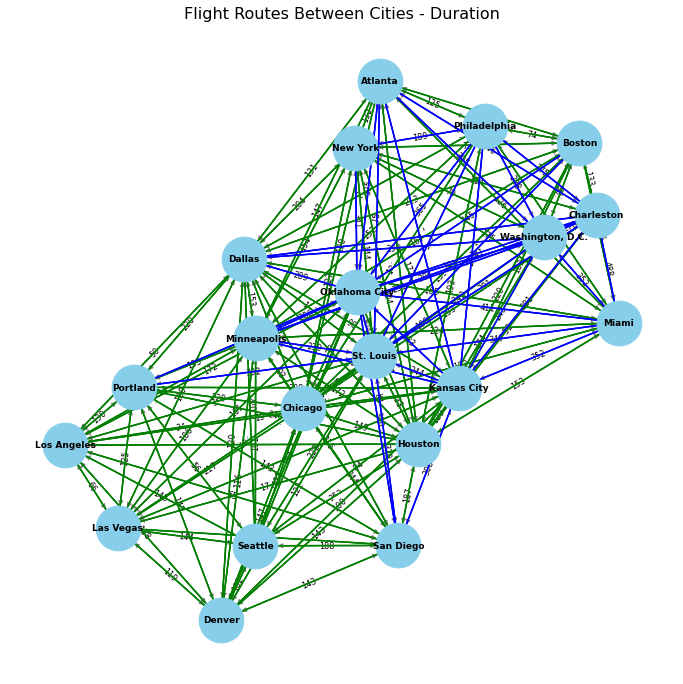

In [62]:
city_route_visualization(flight_duration_data, "Duration", "duration")

### 2. Flight between cities based on fare

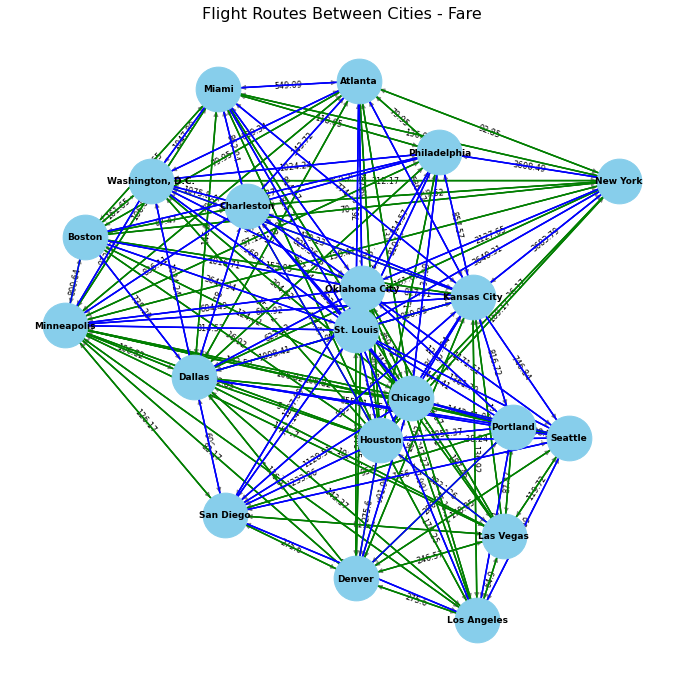

In [63]:
city_route_visualization(flight_fare_data, "Fare", "fare")

### 3. Flight between cities based on duration and fare

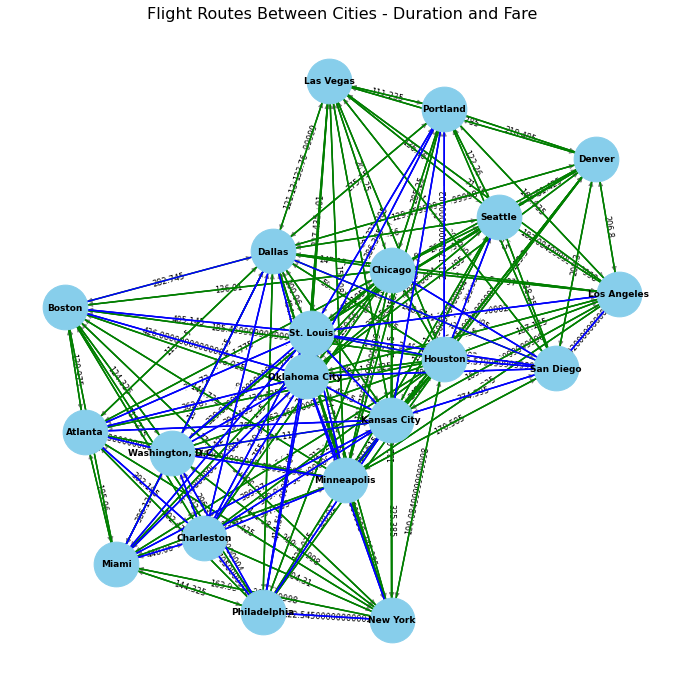

In [64]:
city_route_visualization(flight_weight_data, "Duration and Fare", "weight")

In [65]:
flight_data = flight_duration_data

## **Dijkstra's Algorithm**

### 1. Create Node Class

In [66]:
# Node = (vertex, duration)
class Node:
    def __init__(self, v, duration):
        self.v = v
        self.duration = duration
        
    def __lt__(self, other):
        return self.duration < other.duration

In [67]:
based_on_condition("duration_minutes")

'duration_minutes'

### 2. Dijkstra's algorithm

In [68]:
# Dijkstra's algorithm for shortest path
def dijkstra(flight_data, start, destination, on):
    based_on = based_on_condition(on)
    visited = set()
    based_on_map = dict()
    parent_map = dict()
    priority_queue = []

    # Initialize the starting point with a based_on of 0
    first_node = Node(start, 0)
    based_on_map[start] = 0
    heapq.heappush(priority_queue, first_node)

    while priority_queue:
        curr_node = heapq.heappop(priority_queue)
        curr_vertex = curr_node.v
        # If already visited, skip
        if curr_vertex in visited:
            continue
        visited.add(curr_vertex)

        # If we reached the destination, stop early
        if curr_vertex == destination:
            break

        # Get all neighbors and their durations
        curr_neighbors = flight_data.get(curr_vertex, {}).keys()
        for neighbor_vertex in curr_neighbors:
            if neighbor_vertex not in visited:
                # Handle both direct and 1-stop flight durations
                if 'direct' in flight_data[curr_vertex][neighbor_vertex]:
                    neighbor_min = flight_data[curr_vertex][neighbor_vertex]['direct']
                elif '1 stop' in flight_data[curr_vertex][neighbor_vertex]:
                    neighbor_min = flight_data[curr_vertex][neighbor_vertex]['1 stop'][based_on]

                # Update the based_on_map if a shorter path is found
                if neighbor_vertex not in based_on_map:
                    based_on_map[neighbor_vertex] = sys.maxsize

                if based_on_map[curr_vertex] + neighbor_min < based_on_map[neighbor_vertex]:
                    based_on_map[neighbor_vertex] = based_on_map[curr_vertex] + neighbor_min
                    parent_map[neighbor_vertex] = curr_vertex
                    neighbor_node = Node(neighbor_vertex, based_on_map[neighbor_vertex])
                    heapq.heappush(priority_queue, neighbor_node)
                    
    return parent_map, based_on_map

### 3. Create helper function to print out the path

In [69]:
def reconstruct_path(flight_data, parent_map, start, destination):
    path = []
    
    # If destination is in parent_map or destination is the start point
    if destination in parent_map or destination == start:
        current = destination
        while current != start:
            path.append(current)
            
            # Get the previous city in the path
            previous = parent_map[current]
            
            # Check if the flight between previous and current is '1 stop' and add the layover
            if previous in flight_data and current in flight_data[previous]:
                if '1 stop' in flight_data[previous][current]:
                    layover = flight_data[previous][current]['1 stop'].get('layovers')
                    if layover and layover not in path:
                        path.append(layover)  # Add layover only if it's not already in the path
                        
            # Move to the next city in the path
            current = previous
                
        path.append(start)
        path.reverse()  # Reverse to get the correct order
    
    return path

### 3.Testing Dijkstra's Algorithm

In [70]:
def test_dijkstra(on):
    start = 'Portland'
    destination = 'Miami'
    
    parent_map, based_on_map = dijkstra(flight_data, start, destination, on)
    print(parent_map)
    print(based_on_map)
    path = reconstruct_path(flight_data, parent_map, start, destination)
    
    print("Shortest path:", path)
    print(f"Shortest {on}:", based_on_map[destination])

# Run the test case
test_dijkstra("duration")

{'Los Angeles': 'Portland', 'Las Vegas': 'Portland', 'Seattle': 'Portland', 'San Diego': 'Portland', 'Denver': 'Portland', 'Chicago': 'Portland', 'Dallas': 'Los Angeles', 'Houston': 'Dallas', 'St. Louis': 'Denver', 'Kansas City': 'Portland', 'Oklahoma City': 'Denver', 'Minneapolis': 'Portland', 'New York': 'Minneapolis', 'Washington, D.C.': 'Chicago', 'Philadelphia': 'Minneapolis', 'Miami': 'Dallas', 'Charleston': 'Chicago', 'Atlanta': 'Dallas', 'Boston': 'Minneapolis'}
{'Portland': 0, 'Los Angeles': 130, 'Las Vegas': 125, 'Seattle': 56, 'San Diego': 143, 'Denver': 147, 'Chicago': 229, 'Dallas': 180, 'Houston': 240, 'St. Louis': 269, 'Kansas City': 208, 'Oklahoma City': 251, 'Minneapolis': 195, 'New York': 349, 'Washington, D.C.': 337, 'Philadelphia': 347, 'Miami': 345, 'Charleston': 362, 'Atlanta': 311, 'Boston': 362}
Shortest path: ['Portland', 'Los Angeles', 'Dallas', 'Miami']
Shortest duration: 345


## A* Algorithm

### 1. Direct distance calculation

#### 1-1. Record geo coordinates of cities

In [71]:
# Coordinates of the cities (latitude, longitude)
cities_coordinates = {
    'New York': (40.7128, -74.0060),
    'Boston': (42.3601, -71.0589),
    'Washington, D.C.': (38.9072, -77.0369),
    'Philadelphia': (39.9526, -75.1652),
    'Miami': (25.7617, -80.1918),
    'Charleston': (32.7765, -79.9311),
    'Atlanta': (33.7490, -84.3880),
    'Los Angeles': (34.0522, -118.2437),
    'Las Vegas': (36.1699, -115.1398),
    'Seattle': (47.6062, -122.3321),
    'San Diego': (32.7157, -117.1611),
    'Denver': (39.7392, -104.9903),
    'Portland': (45.5051, -122.6750),
    'Chicago': (41.8781, -87.6298),
    'Dallas': (32.7767, -96.7970),
    'Houston': (29.7604, -95.3698),
    'St. Louis': (38.6270, -90.1994),
    'Kansas City': (39.0997, -94.5786),
    'Oklahoma City': (35.4676, -97.5164),
    'Minneapolis': (44.9778, -93.2650)
}
# Merge all cities from the regions
all_cities = cities_east + cities_west + cities_mid

#### 1-2. Calculate direct distance in kilometer

In [72]:
# Function to calculate the distances between each pair of cities
def calculate_distances(cities):
    distances = {}  # Dictionary to store distances between cities
    for city_a in cities:
        for city_b in cities:
            if city_a != city_b:  # Skip the same city pair
                # Calculate the distance using geodesic (great-circle distance)
                dist = geodesic(cities_coordinates[city_a], cities_coordinates[city_b]).kilometers
                # Store the distance in the dictionary with both directions
                distances[(city_a, city_b)] = dist
            else:
                distances[(city_a, city_b)] = 0
    return distances

# Calculate and store the distances between all cities
distances_map = calculate_distances(all_cities)

#### 1-3. Create helper function to get direct distance between cities

In [73]:
# Function to get the heuristic distance between two cities
def heuristic(city_a, city_b):
    # Handle missing distance gracefully
    dist = distances_map.get((city_a, city_b)) or distances_map.get((city_b, city_a))
    if dist is None:
        raise ValueError(f"No distance data available for {city_a} to {city_b}")
    return dist*0.1

# Test the function with some city pairs
print(f"Distance from New York to Boston: {heuristic('Portland', 'Minneapolis'):.2f} km")
print(f"Distance from New York to Boston: {heuristic('Portland', 'Chicago'):.2f} km")


Distance from New York to Boston: 229.69 km
Distance from New York to Boston: 283.10 km


### 2. A* algorithm

#### 2-1. Create Node Star Class

In [74]:
class Node_Star:
    def __init__(self, v, g_cost, h_cost):
        # Initialize the node with the city (v), actual cost to reach this node (g_cost),
        # heuristic cost (h_cost), and total estimated cost (f_cost = g_cost + h_cost)
        self.v = v
        self.g_cost = g_cost  # Actual cost from start to current node
        self.h_cost = h_cost  # Heuristic cost (estimated cost from current node to destination)
        self.f_cost = g_cost + h_cost  # f = g + h (total estimated cost)

    def __lt__(self, other):
        # Comparison function to make sure the heap is ordered by f_cost
        return self.f_cost < other.f_cost

In [75]:
# A* Algorithm Implementation
def a_star(flight_data, start, destination, heuristic, on):
    based_on = based_on_condition(on)
    open_list = []  # Priority queue (heap) for open nodes
    closed_list = set()  # Set of visited cities (closed nodes)
    g_costs = {start: 0}  # Dictionary to store the actual cost from start to each city
    parent_map = {}  # Dictionary to store the parent city of each city (for path reconstruction)

    # Initialize the start node
    start_node = Node_Star(start, 0, heuristic(start, destination))
    heapq.heappush(open_list, start_node)

    while open_list:
        # Pop the node with the lowest f_cost from the priority queue
        current_node = heapq.heappop(open_list)
        current_city = current_node.v

        # If we reached the destination, we can stop
        if current_city == destination:
            break

        closed_list.add(current_city)

        # Loop through neighbors of the current city
        for neighbor in flight_data.get(current_city, {}).keys():
            if neighbor in closed_list:
                continue

            # Calculate the cost to travel from current city to the neighbor
            if 'direct' in flight_data[current_city][neighbor]:
                travel_cost = flight_data[current_city][neighbor]['direct']
            elif '1 stop' in flight_data[current_city][neighbor]:
                travel_cost = flight_data[current_city][neighbor]['1 stop'][based_on]
            
            tentative_g_cost = g_costs[current_city] + travel_cost  # Tentative cost to reach neighbor

            # If the neighbor is not in g_costs or we found a cheaper path
            if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                g_costs[neighbor] = tentative_g_cost
                f_cost = tentative_g_cost + heuristic(neighbor, destination)  # Total estimated cost (f = g + h)
                neighbor_node = Node_Star(neighbor, tentative_g_cost, heuristic(neighbor, destination))
                parent_map[neighbor] = current_city
                heapq.heappush(open_list, neighbor_node)

    return parent_map, g_costs

### 3.Testing A* Algorithm

#### 3-1. Test heuristic function

In [76]:
start = 'Seattle'
destination = 'Miami'
print(heuristic(start, destination))

440.04754357832763


#### 3-2. Test A* algorithm

In [77]:
def test_a_star(on):
    start = 'Portland'
    destination = 'Miami'
    
    parent_map, duration_map = a_star(flight_data, start, destination, heuristic, on)
    print(parent_map)
    print(duration_map)
    path = reconstruct_path(flight_data,parent_map, start, destination)
    
    print("Shortest path:", path)
    print("Shortest duration:", duration_map[destination])

# Run the test case
test_a_star("duration")

{'Los Angeles': 'Portland', 'Las Vegas': 'Portland', 'Seattle': 'Portland', 'San Diego': 'Portland', 'Denver': 'Portland', 'Chicago': 'Portland', 'Dallas': 'Portland', 'Houston': 'Portland', 'St. Louis': 'Portland', 'Kansas City': 'Portland', 'Oklahoma City': 'Portland', 'Minneapolis': 'Portland', 'New York': 'Dallas', 'Washington, D.C.': 'Dallas', 'Philadelphia': 'Dallas', 'Miami': 'Dallas', 'Charleston': 'Dallas', 'Atlanta': 'Dallas', 'Boston': 'Dallas'}
{'Portland': 0, 'Los Angeles': 130, 'Las Vegas': 125, 'Seattle': 56, 'San Diego': 143, 'Denver': 147, 'Chicago': 229, 'Dallas': 220, 'Houston': 246, 'St. Louis': 332, 'Kansas City': 208, 'Oklahoma City': 314, 'Minneapolis': 195, 'New York': 424, 'Washington, D.C.': 518, 'Philadelphia': 422, 'Miami': 385, 'Charleston': 561, 'Atlanta': 351, 'Boston': 433}
Shortest path: ['Portland', 'Dallas', 'Miami']
Shortest duration: 385


## Compare Djkstra and A* Algorithms

### 1. Comparison helper functions

In [78]:
def clear_cache():
    gc.collect()  # Force garbage collection to clear memory cache

# Function to time the Dijkstra algorithm and return the execution time along with the path
def time_dijkstra(flight_data, origin, destination, on):
    start_time = time.time()  # Start time measurement
    parent_map, based_on_map = dijkstra(flight_data, origin, destination, on)  # Run Dijkstra algorithm
    end_time = time.time()  # End time measurement
    path = reconstruct_path(flight_data, parent_map, origin, destination)  # Reconstruct the path

    return path, end_time - start_time, based_on_map  # Return the path and the time taken

# Function to time the A* algorithm and return the execution time along with the path
def time_a_star(flight_data, origin, destination, heuristic, on):
    start_time = time.time()  # Start time measurement
    parent_a_star_map, based_on_astar_map = a_star(flight_data, origin, destination, heuristic, on)  # Run A* algorithm
    path_a_star = reconstruct_path(flight_data, parent_a_star_map, origin, destination)  # Reconstruct the path
    end_time = time.time()  # End time measurement
    return path_a_star, end_time - start_time, based_on_astar_map  # Return the path and the time taken

In [79]:
# Function to compare the two algorithms by running them multiple times
def compare_algorithms(flight_data, origin, destination, heuristic, on, runs=100):
    dijkstra_times = []  # List to store Dijkstra times
    a_star_times = []  # List to store A* times
    dijkstra_paths = []  # List to store Dijkstra paths
    a_star_paths = []  # List to store A* paths
    dijkstra_durations = []  # List to store Dijkstra paths
    a_star_durations = []  # List to store A* paths
    clear_cache()
    # Run Dijkstra algorithm multiple times to average out the time
    for i in range(runs):
        clear_cache()
        path, run_time,duration = time_dijkstra(flight_data, origin, destination, on)  # Run Dijkstra
        dijkstra_times.append(run_time)
        dijkstra_paths.append(path)
        dijkstra_durations.append(duration)
    clear_cache()
    # Run A* algorithm multiple times to average out the time
    for i in range(runs):
        clear_cache()
        path_a_star, run_time, duration = time_a_star(flight_data, origin, destination, heuristic, on)  # Run A*
        a_star_times.append(run_time)
        a_star_paths.append(path_a_star)
        a_star_durations.append(duration)

    # Calculate the average time for both algorithms
    avg_dijkstra_time = sum(dijkstra_times) / runs
    avg_a_star_time = sum(a_star_times) / runs

    # Get the last path (or you could choose the average path if needed)
    avg_dijkstra_path = dijkstra_paths[0]
    avg_a_star_path = a_star_paths[0]
    
    avg_dijkstra_duration = dijkstra_durations[0][destination]
    avg_a_star_duration = a_star_durations[0][destination]

    return avg_dijkstra_time, avg_a_star_time, avg_dijkstra_path, avg_a_star_path, avg_dijkstra_duration, avg_a_star_duration


### 2. Comparison visualizations

In [80]:
# Function to visualize and compare the results of both algorithms
def plot_comparison(flight_data, Origin, Destination, dijkstra_path, a_star_path, dijkstra_time, a_star_time, avg_dijkstra_duration, avg_a_star_duration):
    # Prepare the information for A* algorithm
    a_star_info = f"A* Path: {a_star_path}\nA* shortest duarion: {avg_a_star_duration}\nA* Algorithm runtime: {a_star_time:.4f} seconds"
    dijkstra_info = f"Dijkstra Path: {dijkstra_path}\nDijkstra Algorithm shortest duarion: {avg_dijkstra_duration}\nDijkstra Algorithm runtime: {dijkstra_time:.4f} seconds"

    # Combine the information for both algorithms
    comparison_info = f"{dijkstra_info}\n\n{a_star_info}"

    # Adjust the figure size to add more vertical space
    plt.figure(figsize=(8, 6), dpi=300)  # Increase height (e.g., 8) to make room for the text

    # Plot the runtime comparison
    plt.plot([1], [dijkstra_time], marker='o', label="Dijkstra's Algorithm", color='steelblue')  # Plot Dijkstra runtime
    plt.plot([1], [a_star_time], marker='o', label="A* Algorithm", color='indianred')           # Plot A* runtime
    plt.title("Algorithm Running Time Comparison")  # Set the plot title
    #plt.xlabel("Run Number")                        # Label for the x-axis
    plt.ylabel("Time (seconds)")                    # Label for the y-axis
    plt.xticks([1], labels=[""])               # Set the x-axis tick to indicate "Run 1"
    plt.legend()                                    # Add legend to the plot
    plt.subplots_adjust(bottom=0.2)
    # Add algorithm information to the plot (at the top, in the extra space)
    plt.gcf().text(
        0.12, -0.01,  # Position near the top of the figure
        comparison_info,
        fontsize=10, 
        verticalalignment='bottom',  # Align text to the top
        horizontalalignment='left',  # Align text to the left
    )
    
    # Save the figure with the updated size and layout
    filename = f"./results/{Origin}_to_{Destination}_algorithm_run_time_comparison.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save the figure with high resolution
    plt.show()  # Display the plot

    # Print the filename confirmation
    print(f"File saved as: {filename}")

### 3. Test comparison functions

In [81]:
def test_comparison(data, origin, destination, heuristic_function, on):
    avg_dijkstra_time, \
    avg_a_star_time, \
    avg_dijkstra_path, \
    avg_a_star_path, \
    avg_dijkstra_duration, \
    avg_a_star_duration = compare_algorithms(data, origin, destination, heuristic_function, on)
    # Print the average times for both algorithms
    print(f'Dijkstra Average Time: {avg_dijkstra_time} seconds')
    print(f'A* Average Time: {avg_a_star_time} seconds')

    # Visualize the comparison and save the result as an image
    plot_comparison(flight_data, origin, destination, avg_dijkstra_path, avg_a_star_path, avg_dijkstra_time, avg_a_star_time,avg_dijkstra_duration, avg_a_star_duration)

    return avg_dijkstra_time, avg_a_star_time, avg_dijkstra_path, avg_a_star_path, avg_dijkstra_duration, avg_a_star_duration

Dijkstra Average Time: 0.0001358652114868164 seconds
A* Average Time: 7.826089859008789e-05 seconds


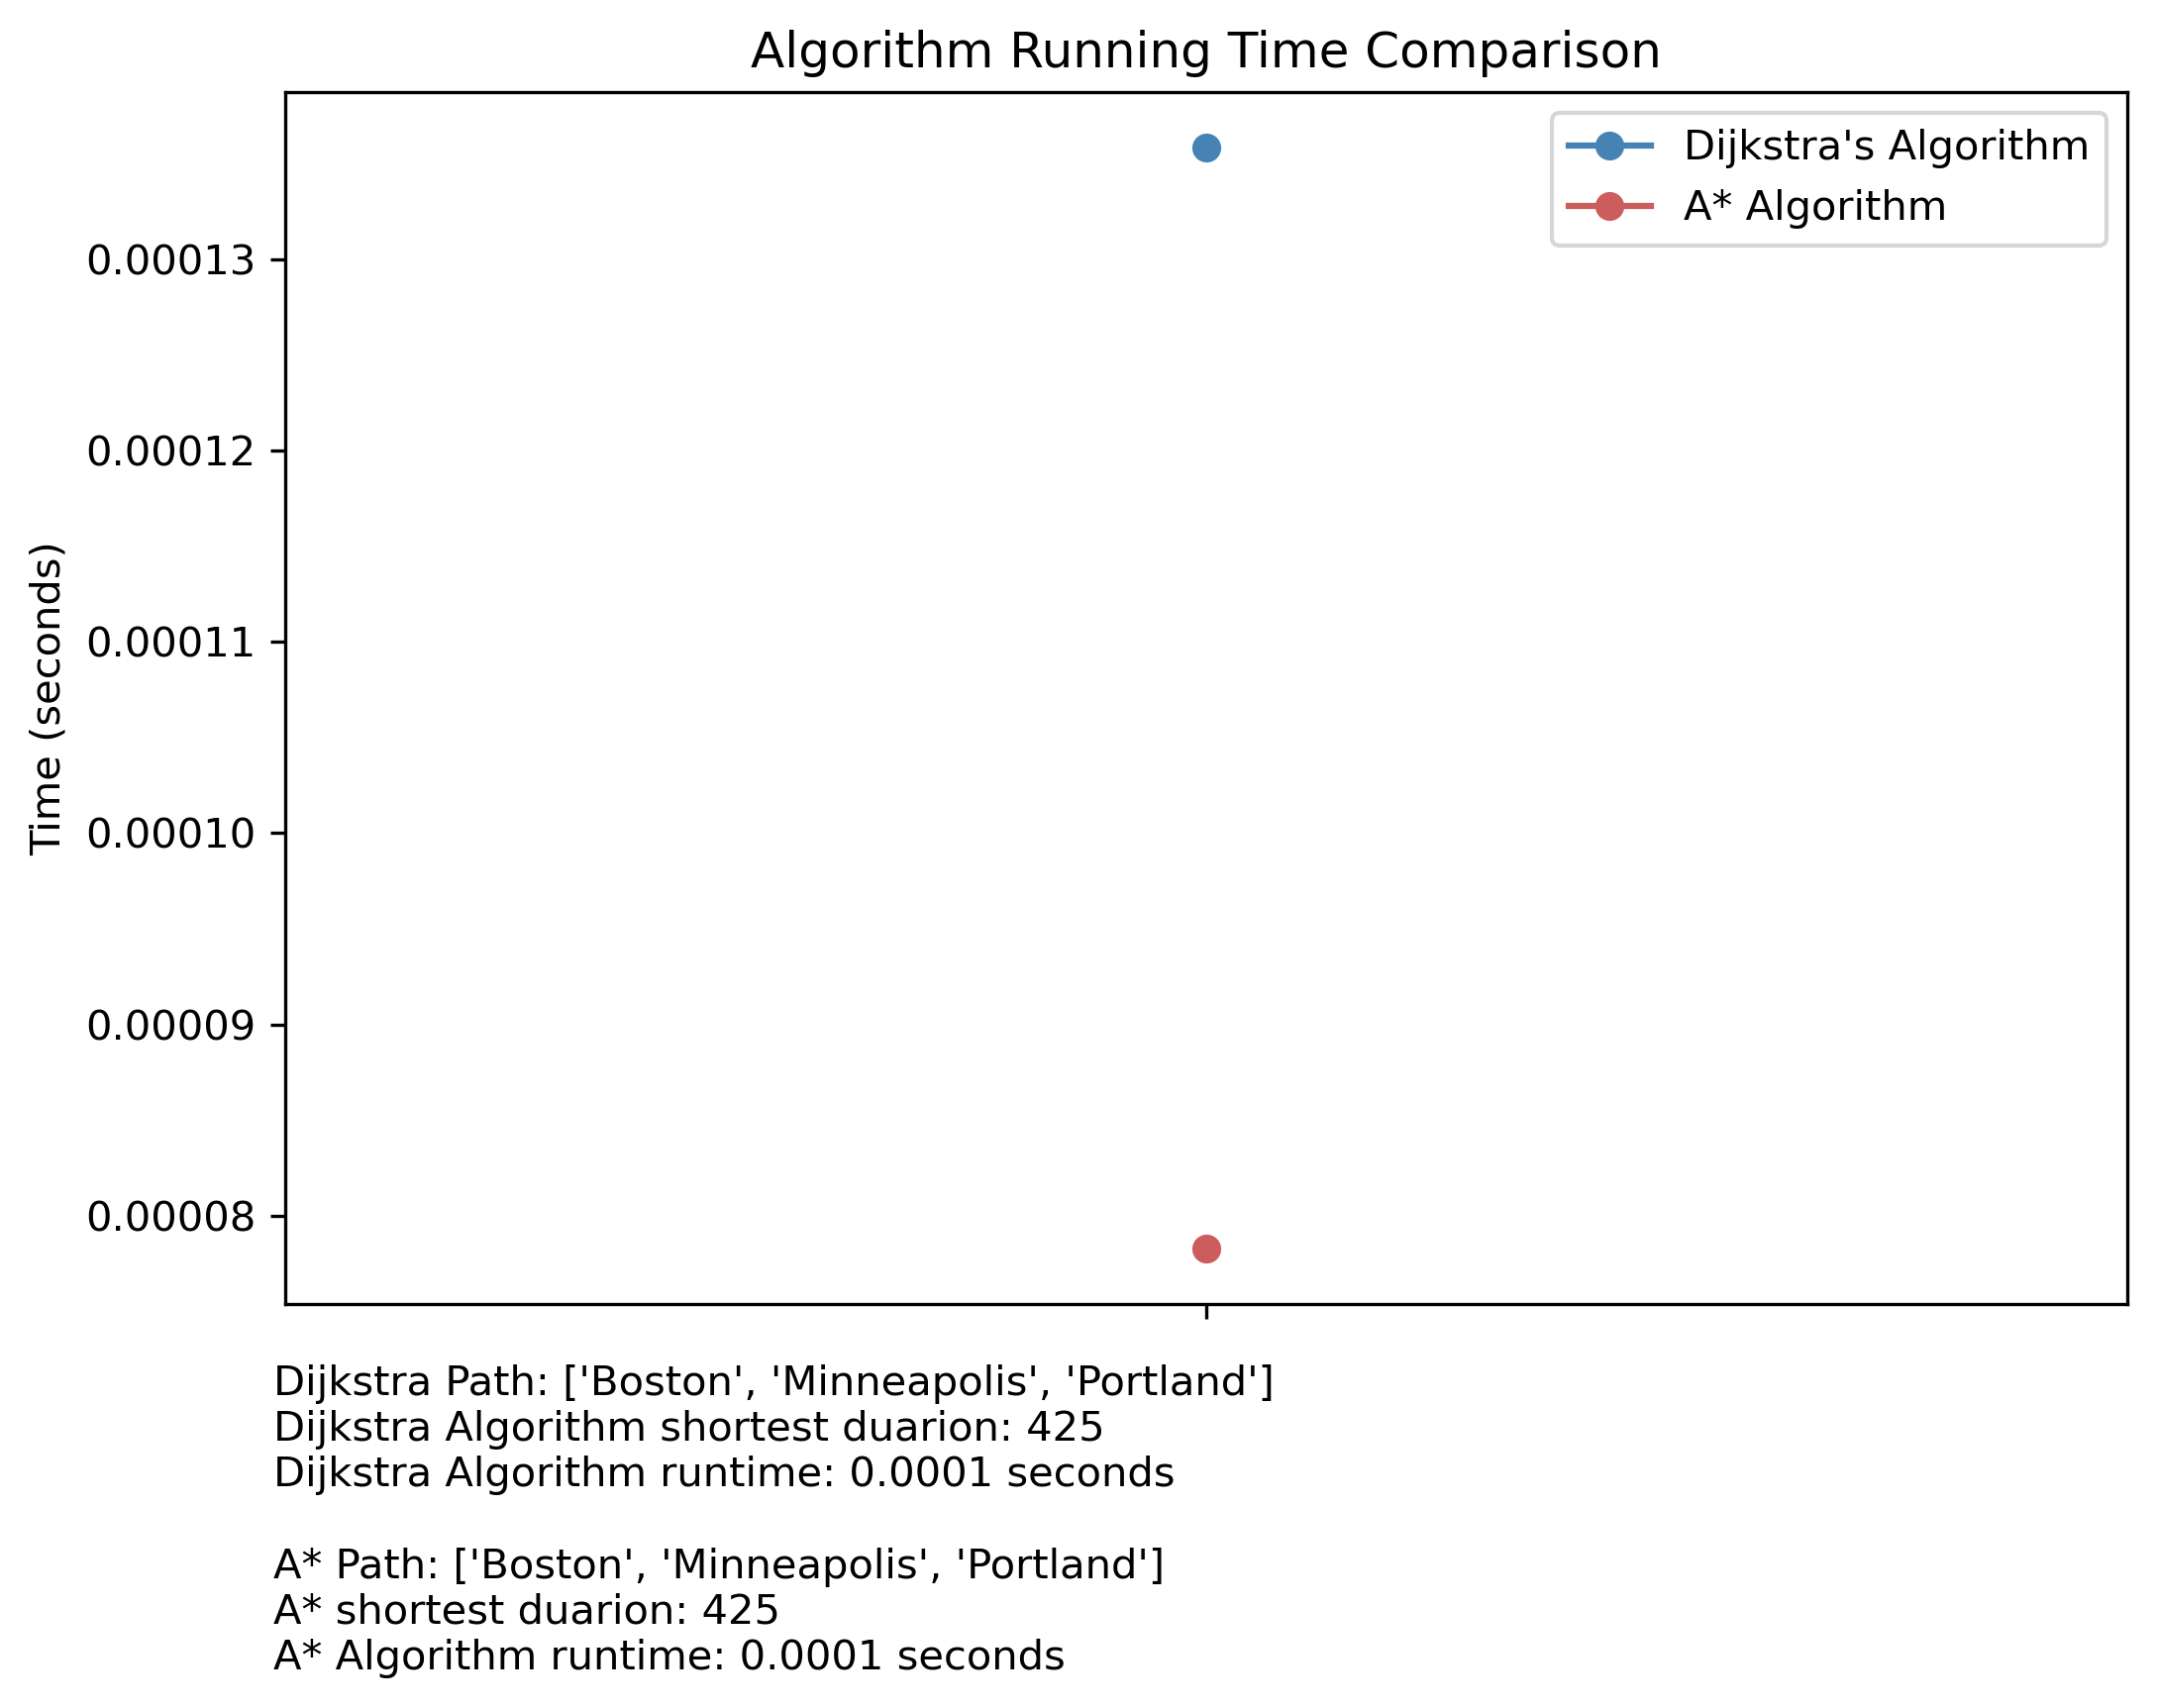

File saved as: ./results/Boston_to_Portland_algorithm_run_time_comparison.png


In [82]:
test_comparison = test_comparison(flight_data, 'Boston', 'Portland', heuristic, "duration")

**Notes:** \
The discrepancy in runtimes when switching the execution order of Dijkstra and A* algorithms likely arises due 
to caching effects, initialization overhead, or memory reuse in the program execution. \
\
Running one algorithm first might initialize shared data structures or take advantage of cached data, leading to a faster runtime for subsequent runs. This can create an artificial advantage for the algorithm that runs second.

## Visualize Path

In [83]:
def get_coordinates(city):
    # Use Geopy to get the coordinates of the cities
    geolocator = Nominatim(user_agent="city_map")
    location = geolocator.geocode(city)
    if location:
        return location.latitude, location.longitude
    else:
        return None

# Get the coordinates for cities in the East, West, and Mid
coordinates = {}
for city in all_cities:
    coord = get_coordinates(city)
    if coord:
        coordinates[city] = coord

# Create a dataframe from the coordinates
city_df = pd.DataFrame(coordinates).T
city_df.columns = ['Latitude', 'Longitude']

In [84]:
def visualize_path(path, origin, destination):
    # Get coordinates for the cities in the flight path
    path_coords = [coordinates[city] for city in path]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the cities' positions
    for city, coord in coordinates.items():
        # Default label style
        label_color = 'steelblue'  # Default label color
        label_fontweight = 'normal'  # Default font weight
        label_fontsize = 10  # Default font size
        marker_style = 'o'  # Default city marker style (circle)
        marker_size = 40  # Default city marker size
        
        # Special styling for specific cities
        if city in path:
            label_color = 'indianred'
            label_fontweight = 'bold'
            label_fontsize = 12
            marker_style = '*'  # Red five-pointed star
            marker_size = 150  # Larger five-pointed star marker
        
        # Plot city positions, setting z-order to the bottom layer (cities at the bottom)
        ax.scatter(coord[1], coord[0], color=label_color, marker=marker_style, s=marker_size, label=city, zorder=1)
        
        # Set labels, setting z-order to the top layer (text and stars on top)
        ax.text(coord[1] + 0.5, coord[0] + 0.5, city, fontsize=label_fontsize, ha='center', color=label_color, fontweight=label_fontweight, zorder=3)

    # Draw the path, using unidirectional arrows, setting z-order to the second-to-last layer (arrows in the middle)
    for i in range(len(path_coords) - 1):
        start_coord = path_coords[i]
        end_coord = path_coords[i + 1]
        
        # Draw the arrows connecting the path, setting z-order to the second-to-last layer (arrows in the middle)
        ax.annotate('', xy=(end_coord[1], end_coord[0]), xytext=(start_coord[1], start_coord[0]),
                    arrowprops=dict(facecolor='green', edgecolor='olivedrab', arrowstyle='->', lw=2), zorder=2)

    # Set the title
    ax.set_title('Cities and Flight Path with Directions \n Boston to Portland', color="white", size="16")


    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    filename = f"./results/{origin}_to_{destination}_path.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

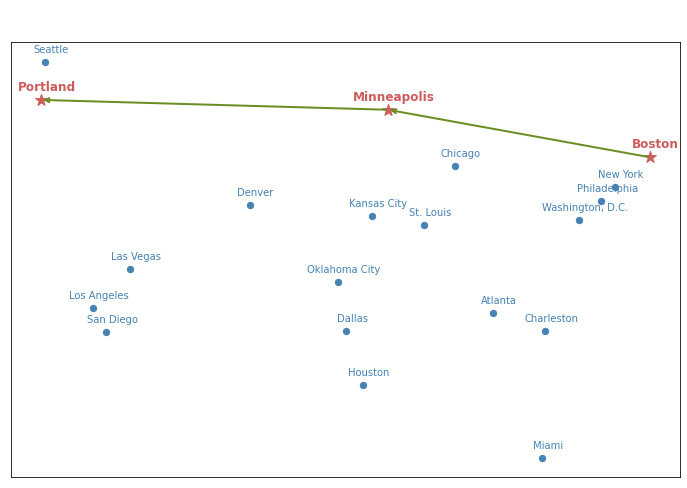

In [85]:
visualize_path(test_comparison[2], "Boston", "Portland")

## Results

In [88]:
def get_comparison(data, res_list, on):
    dijkstra_time = 0
    astar_time = 0
    dijkstra_total_path = 0
    astar_total_path = 0
    count = 0

    for city_w in cities_west:
        for city_e in cities_east:
            res = compare_algorithms(data, city_w, city_e, heuristic, on)
            res_list.append(res)
            dijkstra_time += res[0]
            astar_time += res[1]
            dijkstra_total_path += len(res[2])
            astar_total_path += len(res[3])
            count += 1 
    avg_dijkstra_time = dijkstra_time / count
    avg_astar_time = astar_time / count
    avg_dijkstra_path = dijkstra_total_path / count
    avg_astar_path = astar_total_path / count
    return [avg_dijkstra_time, avg_astar_time, avg_dijkstra_path, avg_astar_path, res_list]

In [89]:
duration_list = list()
duration_comparison_result = get_comparison(flight_duration_data, duration_list, "duration")
duration_comparison_result

[0.00013268169902619858,
 0.00010057256335303897,
 3.4761904761904763,
 3.0476190476190474,
 [(0.00013796091079711914,
   0.00010097742080688476,
   ['Los Angeles', 'Dallas', 'New York'],
   ['Los Angeles', 'Dallas', 'New York'],
   254,
   254),
  (0.00015398979187011719,
   9.93037223815918e-05,
   ['Los Angeles', 'Dallas', 'Boston'],
   ['Los Angeles', 'Dallas', 'Boston'],
   263,
   263),
  (0.00014787435531616211,
   0.00014053583145141603,
   ['Los Angeles', 'Dallas', 'Houston', 'Washington, D.C.'],
   ['Los Angeles', 'Dallas', 'Chicago', 'Washington, D.C.'],
   284,
   294),
  (0.0001323390007019043,
   9.460687637329102e-05,
   ['Los Angeles', 'Dallas', 'Philadelphia'],
   ['Los Angeles', 'Dallas', 'Philadelphia'],
   252,
   252),
  (0.00014101028442382814,
   8.797168731689454e-05,
   ['Los Angeles', 'Dallas', 'Miami'],
   ['Los Angeles', 'Dallas', 'Miami'],
   215,
   215),
  (0.00012850522994995117,
   9.151697158813477e-05,
   ['Los Angeles', 'Dallas', 'Houston', 'Charlest

In [90]:
fare_list = list()
fare_comparison_result = get_comparison(flight_fare_data, fare_list, "fare")
fare_comparison_result

[0.00013185461362202964,
 0.00011027659688677105,
 3.4285714285714284,
 3.4047619047619047,
 [(0.00014111995697021484,
   9.100675582885742e-05,
   ['Los Angeles', 'Minneapolis', 'New York'],
   ['Los Angeles', 'Minneapolis', 'New York'],
   260.94,
   260.94),
  (0.0001392960548400879,
   0.00010756969451904297,
   ['Los Angeles', 'Minneapolis', 'Atlanta', 'Boston'],
   ['Los Angeles', 'Minneapolis', 'New York', 'Boston'],
   280.69,
   331.21),
  (0.00015294313430786133,
   0.0001652383804321289,
   ['Los Angeles', 'Minneapolis', 'New York', 'Washington, D.C.'],
   ['Los Angeles', 'Minneapolis', 'New York', 'Washington, D.C.'],
   473.11,
   473.11),
  (0.0001232767105102539,
   8.042097091674805e-05,
   ['Los Angeles', 'Minneapolis', 'Philadelphia'],
   ['Los Angeles', 'Minneapolis', 'Philadelphia'],
   227.62,
   227.62),
  (0.00012708187103271484,
   7.688760757446289e-05,
   ['Los Angeles', 'Minneapolis', 'Miami'],
   ['Los Angeles', 'Dallas', 'Miami'],
   237.29,
   289.97),
  (

In [91]:
weight_list = list()
weight_comparison_data = get_comparison(flight_weight_data, weight_list, "weight")
weight_comparison_data

[0.00011486331621805826,
 9.271388962155298e-05,
 3.261904761904762,
 3.2857142857142856,
 [(0.00011996984481811523,
   8.355379104614258e-05,
   ['Los Angeles', 'Dallas', 'New York'],
   ['Los Angeles', 'Dallas', 'New York'],
   296.375,
   296.375),
  (0.00012079238891601562,
   7.413148880004883e-05,
   ['Los Angeles', 'Minneapolis', 'Boston'],
   ['Los Angeles', 'Minneapolis', 'Boston'],
   320.97,
   320.97),
  (0.0001257801055908203,
   0.00014657020568847656,
   ['Los Angeles', 'Dallas', 'Chicago', 'Washington, D.C.'],
   ['Los Angeles', 'Dallas', 'Chicago', 'Washington, D.C.'],
   430.205,
   430.205),
  (0.00011355638504028321,
   8.196830749511719e-05,
   ['Los Angeles', 'Dallas', 'Philadelphia'],
   ['Los Angeles', 'Dallas', 'Philadelphia'],
   287.075,
   287.075),
  (0.00010994434356689453,
   7.415056228637695e-05,
   ['Los Angeles', 'Dallas', 'Miami'],
   ['Los Angeles', 'Dallas', 'Miami'],
   273.85,
   273.85),
  (0.0001186370849609375,
   0.00013627052307128905,
   ['

## Result Analysis

### 1. Average Run Time Analysis

In [92]:
all_results = [{"type": "duration", "avg_dijkstra_time": duration_comparison_result[0], "avg_astar_time": duration_comparison_result[1], "avg_dijkstra_path": duration_comparison_result[2], "avg_astar_path": duration_comparison_result[3]}, 
               {"type": "fare", "avg_dijkstra_time": fare_comparison_result[0], "avg_astar_time": fare_comparison_result[1], "avg_dijkstra_path": fare_comparison_result[2], "avg_astar_path": fare_comparison_result[3]},
               {"type": "weight", "avg_dijkstra_time": weight_comparison_data[0], "avg_astar_time": weight_comparison_data[1], "avg_dijkstra_path": weight_comparison_data[2], "avg_astar_path": weight_comparison_data[3]}]
results_df = pd.DataFrame(all_results)
results_df

,type,avg_dijkstra_time,avg_astar_time,avg_dijkstra_path,avg_astar_path
0,duration,0.000133,0.000101,3.476190,3.047619
1,fare,0.000132,0.000110,3.428571,3.404762
2,weight,0.000115,0.000093,3.261905,3.285714


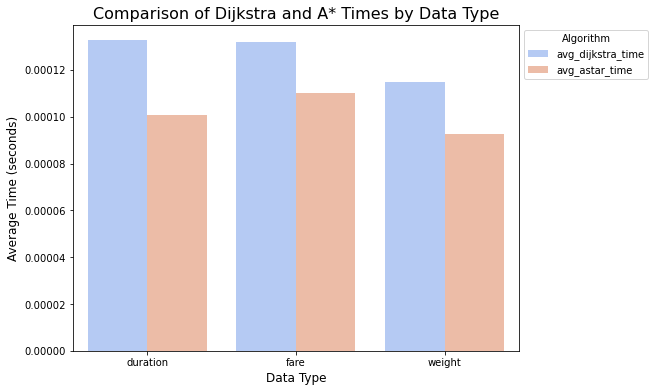

In [93]:
# Melt the DataFrame to create a long-form representation suitable for seaborn
results_melted = results_df.melt(id_vars='type', 
                                       value_vars=['avg_dijkstra_time', 'avg_astar_time'], 
                                       var_name='Algorithm', 
                                       value_name='Time')

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=results_melted, x='type', y='Time', hue='Algorithm', palette='coolwarm')

# Customize the plot
plt.title('Comparison of Dijkstra and A* Times by Data Type', fontsize=16)
plt.xlabel('Data Type', fontsize=12)
plt.ylabel('Average Time (seconds)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Algorithm', fontsize=10)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
plt.savefig('./results/Comparison of Dijkstra and A* Times by Data Type.png')
plt.show()

### 2. Average Number of Paths Analysis

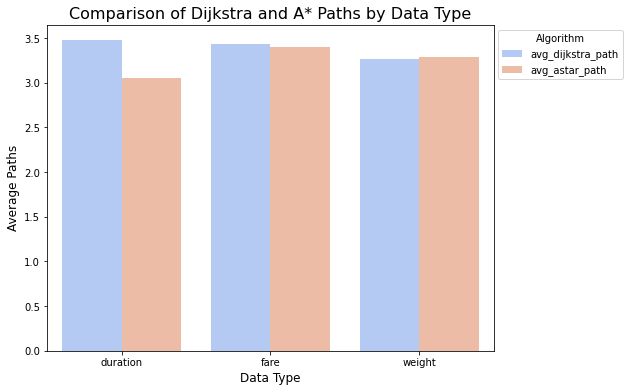

In [94]:
# Melt the DataFrame to create a long-form representation suitable for seaborn
results_melted = results_df.melt(id_vars='type', 
                                       value_vars=['avg_dijkstra_path', 'avg_astar_path'], 
                                       var_name='Algorithm', 
                                       value_name='Paths')

# Create a bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=results_melted, x='type', y='Paths', hue='Algorithm', palette='coolwarm')

# Customize the plot
plt.title('Comparison of Dijkstra and A* Paths by Data Type', fontsize=16)
plt.xlabel('Data Type', fontsize=12)
plt.ylabel('Average Paths', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Algorithm', fontsize=10)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))
plt.savefig("./results/Comparison of Dijkstra and A* Paths by Data Type.png")
plt.show()

Optional: Correlation Between fare and heuristic cost

In [105]:
flights_data_filtered['heuristic_cost'] = flights_data_filtered.apply(lambda row: heuristic(row['origin_city'], row['destination_city']), axis=1)
flights_data_filtered.head()

/var/folders/8b/s7t1zthd0vq01w12h4ss9cz40000gn/T/ipykernel_55717/1020010434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flights_data_filtered['heuristic_cost'] = flights_data_filtered.apply(lambda row: heuristic(row['origin_city'], row['destination_city']), axis=1)


,origin,destination,departure_time,arrival_time,duration,fare,nonstop,layovers,origin_city,destination_city,layovers_city,HOUR,MIN,duration_minutes,layover_count,heuristic_cost
0,EWR,BOS,2024-12-01 21:20:00,2024-12-01 22:39:00,1H19M,108.97,True,None,New York,Boston,NaN,1,19,79,1,30.649049
1,EWR,BOS,2024-12-01 13:04:00,2024-12-01 14:25:00,1H21M,108.97,True,None,New York,Boston,NaN,1,21,81,1,30.649049
2,LGA,BOS,2024-12-01 06:30:00,2024-12-01 07:40:00,1H10M,250.87,True,None,New York,Boston,NaN,1,10,70,1,30.649049
3,LGA,BOS,2024-12-01 08:09:00,2024-12-01 09:20:00,1H11M,250.87,True,None,New York,Boston,NaN,1,11,71,1,30.649049
4,JFK,BOS,2024-12-01 23:30:00,2024-12-02 00:41:00,1H11M,250.87,True,None,New York,Boston,NaN,1,11,71,1,30.649049


In [96]:
correlation = flights_data_filtered['fare'].corr(flights_data_filtered['heuristic_cost'])
print(f"The correlation between flight fare and heuristic cost is: {correlation}")

The correlation between flight fare and heuristic cost is: 0.20364146693108845


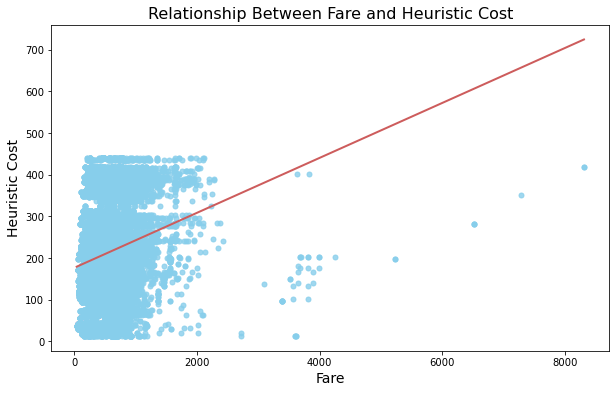

In [97]:
# Create the regplot
plt.figure(figsize=(10, 6)) 
sns.regplot(data=flights_data_filtered, x='fare', y='heuristic_cost', 
            scatter_kws={'color': 'skyblue', 's': 25,},  
            line_kws={'color': 'indianred', 'linewidth': 2}, 
            ci=None)  # Remove confidence interval shading (optional)

# Add a title and axis labels
plt.title('Relationship Between Fare and Heuristic Cost', fontsize=16)
plt.xlabel('Fare', fontsize=14)
plt.ylabel('Heuristic Cost', fontsize=14)
plt.show()

### 3. Duration, Fare, and Weight by Different Algorithm

In [135]:
duration_data = pd.read_csv("./results/duration_result.csv")
fare_data = pd.read_csv("./results/fare_result.csv")
weight_data = pd.read_csv("./results/weight_result.csv")

In [136]:
dijkstra_duration = duration_data['avg_dijkstra_duration'].mean()
astar_duration = duration_data['avg_a_star_duration'].mean()
dijkstra_fare = fare_data['avg_dijkstra_fare'].mean()
astar_fare = fare_data['avg_a_star_fare'].mean()
dijktra_weight = weight_data['avg_dijkstra_weight'].mean()
astar_weight = weight_data['avg_a_star_weight'].mean()
print("Duration:", dijkstra_duration, astar_duration, "\nFare:", dijkstra_fare, astar_fare, "\nWeight:", dijktra_weight, astar_weight)

Duration: 304.2142857142857 317.76190476190476 
Fare: 272.93571428571425 285.237380952381 
Weight: 322.21940476190474 324.5003571428571


### 4. Paths Analysis

In [137]:
compared_cols = ['avg_dijkstra_path', 'avg_a_star_path']
datasets = [duration_data, fare_data, weight_data]
for dataset in datasets:
    for col in compared_cols:
        dataset[col] = dataset[col].apply(str)
        dataset[col] = dataset[col].apply(lambda x: [item.strip() for item in x.split(',')])
for dataset in datasets:
    dataset['same_path'] = dataset[compared_cols[0]] == dataset[compared_cols[1]]
    
# Same path
duration_same_path = duration_data['same_path'].value_counts()
fare_same_path = fare_data['same_path'].value_counts()
weight_same_path = weight_data['same_path'].value_counts()
print("duation:", duration_same_path, "\n"
      "fare:", fare_same_path, "\n"
      "weight:", weight_same_path)

duation: True     21
False    21
Name: same_path, dtype: int64 
fare: True     31
False    11
Name: same_path, dtype: int64 
weight: True     41
False     2
Name: same_path, dtype: int64


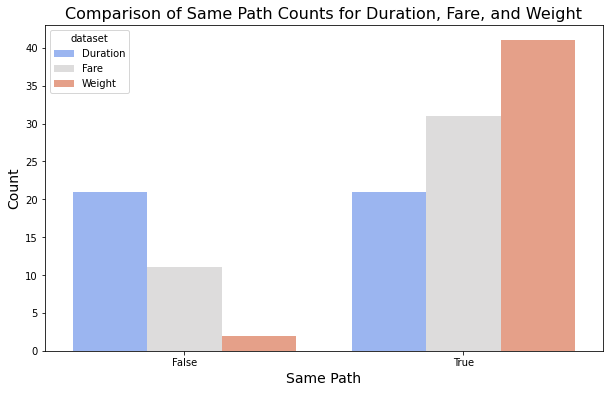

In [138]:
# Combine the value counts from all datasets into a single DataFrame
duration_df = duration_same_path.reset_index()
fare_df = fare_same_path.reset_index()
weight_df = weight_same_path.reset_index()

# Rename columns for consistency
duration_df.columns = ['same_path', 'count']
fare_df.columns = ['same_path', 'count']
weight_df.columns = ['same_path', 'count']

# Add a new column to differentiate the dataset
duration_df['dataset'] = 'Duration'
fare_df['dataset'] = 'Fare'
weight_df['dataset'] = 'Weight'
all_data = pd.concat([duration_df, fare_df, weight_df])

# Set the plot size
plt.figure(figsize=(10, 6))

# Create the bar plot using seaborn
sns.barplot(x='same_path', y='count', hue='dataset', data=all_data, palette='coolwarm')

# Add title and axis labels
plt.title('Comparison of Same Path Counts for Duration, Fare, and Weight', fontsize=16)
plt.xlabel('Same Path', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.savefig("./results/Comparison of Same Path Counts for Duration, Fare, and Weight.png")
plt.show()

In [139]:
# Merge all data
all_results = pd.merge(duration_data, fare_data, left_index=True, right_index=True)
all_results = pd.merge(all_results, weight_data, left_index=True, right_index=True)
# Get number of overlap paths for Dijkstra
same_dijkstra_path = (all_results['avg_dijkstra_path_x'] == all_results['avg_dijkstra_path_y']) &  (all_results['avg_dijkstra_path_y'] == all_results['avg_dijkstra_path'])
same_dijkstra_path = same_dijkstra_path.value_counts()
# Get number of overlap paths for A*
same_astar_path = (all_results['avg_a_star_path_x'] == all_results['avg_a_star_path_y']) &  (all_results['avg_a_star_path_y'] == all_results['avg_a_star_path'])
same_astar_path = same_astar_path.value_counts()
print("Dijkstra:", same_dijkstra_path, "\nA*:", same_astar_path)

Dijkstra: False    38
True      4
dtype: int64 
A*: False    35
True      7
dtype: int64
